In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.tsa.vector_ar.var_model as VAR
import PPCA_MR as p
import statsmodels.api as sm

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Academic papers
Based on Illin, A., Raiko, T. 2010 paper called "Practical Approaches to Principal Component Analysis in the Presence of Missing Values"

Tipping and Bishop (1999) introducted probablistic formulation of PCA (PPCA)


Use a flavor of Probabilistic PCA that is robust to missing data (see Ilin and Raiko 2010). Rather than the vanilla one-shot SVD, PPCA uses an iterative EM procedure/fixed point algorithm. From an initial guess, it’ll alternatively interpolate missing data and update the components until convergence.

On a side note, PPCA interpolates using information from all series, making it a multivariate interpolator. Be careful though, fitting the model to too many components will likely lead to overfitting problems in the interpolated data.

Also note that I am using the standardization that is mentioned in Korajecyk and Sadka (2008) of expanding zscores


In [5]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [7]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [8]:
no_fx = [i for i in data.columns if i not in d_map['Currencies']]
PPCA=p.PPCA()
PPCA.fit(np.array(data[no_fx]),d=no_pc)
sector_variance_explained[sect] = PPCA.var_exp
pcs=pd.DataFrame()
for i in range(0,no_pc,1):
    x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
    x.set_axis(sector_zscores[sect].index)
    pcs[i]=x
sector_PC['Total'] = pcs

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [9]:
prin_factors=pd.DataFrame()
for sector in  ['Agriculturals',
                 'Energies',
                 'Equities',
                 'Metals',
                 'Fixed Income',
                 'Total']:
    prin_factors['Amihud '+sector]=sector_PC[sector].mean(axis=1)

In [10]:
res = VAR.VAR(endog=prin_factors)

In [11]:
res.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -1.215       -1.115       0.2966       -1.175
1        -5.062      -4.357*     0.006332       -4.777
2        -5.645       -4.335     0.003541      -5.115*
3       -5.686*       -3.773    0.003405*       -4.911
4        -5.510       -2.992     0.004080       -4.491
5        -5.483       -2.361     0.004227       -4.218
6        -5.330       -1.604     0.004983       -3.821
7        -5.231      -0.9010     0.005588       -3.478
8        -5.073      -0.1386     0.006689       -3.075
9        -4.944       0.5946     0.007828       -2.702
10       -4.949        1.194     0.008076       -2.462
11       -4.789        1.959     0.009914       -2.057
12       -4.643        2.708      0.01211       -1.667
13       -4.602        3.354      0.01348       -1.381
14       -4.643        3.917      0.01401       -1.177
* Minimum


{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 2}

In [12]:
x=res.fit()

In [13]:
test=x.test_causality('Amihud Total','Amihud Total')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
       303.083580         3.849181            0.000  (1, 1206)
H_0: ['Amihud Total'] do not Granger-cause Amihud Total
Conclusion: reject H_0 at 5.00% significance level


In [14]:
test.values()[4]

9.92300829763048e-61

In [15]:
pvalues=pd.DataFrame()
for col in x.tvalues.columns:
    s=pd.Series()
    for col2 in x.tvalues.columns:
        s[col2]=x.test_causality(col,col2).values()[4]
    pvalues[col]=s
    

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
        43.210429         3.849181            0.000  (1, 1206)
H_0: ['Amihud Agriculturals'] do not Granger-cause Amihud Agriculturals
Conclusion: reject H_0 at 5.00% significance level
Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.614318         3.849181            0.433  (1, 1206)
H_0: ['Amihud Energies'] do not Granger-cause Amihud Agriculturals
Conclusion: fail to reject H_0 at 5.00% significance level
Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.098455         3.849181            0.754  (1, 1206)
H_0: ['Amihud Equities'] do not Granger-cause Amihud Agriculturals
Conclusion: fail to reject H_0 at 5.00% si

In [16]:
print pvalues.round(3).T.to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Amihud Agriculturals &  Amihud Energies &  Amihud Equities &  Amihud Metals &  Amihud Fixed Income &  Amihud Total \\
\midrule
Amihud Agriculturals &                 0.000 &            0.433 &            0.754 &          0.034 &                0.040 &         0.276 \\
Amihud Energies      &                 0.087 &            0.000 &            0.022 &          0.162 &                0.105 &         0.010 \\
Amihud Equities      &                 0.646 &            0.461 &            0.000 &          0.061 &                0.001 &         0.056 \\
Amihud Metals        &                 0.169 &            0.849 &            0.525 &          0.000 &                0.225 &         0.225 \\
Amihud Fixed Income  &                 0.052 &            0.616 &            0.027 &          0.982 &                0.000 &         0.473 \\
Amihud Total         &                 0.517 &            0.948 &            0.003 &          0.164 &                0.006 

In [17]:
print x.resid.corr().round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Amihud Agriculturals &  Amihud Energies &  Amihud Equities &  Amihud Metals &  Amihud Fixed Income &  Amihud Total \\
\midrule
Amihud Agriculturals &                  1.00 &             0.10 &            -0.05 &           0.09 &                 0.17 &          0.05 \\
Amihud Energies      &                  0.10 &             1.00 &             0.15 &           0.04 &                -0.07 &         -0.24 \\
Amihud Equities      &                 -0.05 &             0.15 &             1.00 &           0.24 &                -0.23 &         -0.60 \\
Amihud Metals        &                  0.09 &             0.04 &             0.24 &           1.00 &                -0.13 &         -0.40 \\
Amihud Fixed Income  &                  0.17 &            -0.07 &            -0.23 &          -0.13 &                 1.00 &          0.13 \\
Amihud Total         &                  0.05 &            -0.24 &            -0.60 &          -0.40 &                 0.13 

In [18]:
x.pvalues.T.round(2)

,const,L1.Amihud Agriculturals,L1.Amihud Energies,L1.Amihud Equities,L1.Amihud Metals,L1.Amihud Fixed Income,L1.Amihud Total
Amihud Agriculturals,0.88,0.00,0.43,0.75,0.03,0.04,0.28
Amihud Energies,0.00,0.09,0.00,0.02,0.16,0.11,0.01
Amihud Equities,0.69,0.65,0.46,0.00,0.06,0.00,0.06
Amihud Metals,0.01,0.17,0.85,0.53,0.00,0.23,0.23
Amihud Fixed Income,0.00,0.05,0.62,0.03,0.98,0.00,0.47
Amihud Total,0.09,0.52,0.95,0.00,0.17,0.01,0.00


In [19]:
columns=[ u'L1.Amihud Agriculturals', u'L1.Amihud Energies',
       u'L1.Amihud Equities', u'L1.Amihud Metals', u'L1.Amihud Fixed Income',
       u'L1.Amihud Total']

In [20]:
print x.params.T[columns].round(3).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  L1.Amihud Agriculturals &  L1.Amihud Energies &  L1.Amihud Equities &  L1.Amihud Metals &  L1.Amihud Fixed Income &  L1.Amihud Total \\
\midrule
Amihud Agriculturals &                    0.423 &              -0.087 &               0.020 &            -0.194 &                   0.192 &            0.055 \\
Amihud Energies      &                    0.058 &               0.570 &              -0.078 &             0.068 &                  -0.081 &           -0.069 \\
Amihud Equities      &                   -0.028 &              -0.078 &               0.557 &             0.164 &                  -0.308 &            0.092 \\
Amihud Metals        &                   -0.063 &              -0.015 &               0.029 &             0.569 &                  -0.080 &           -0.043 \\
Amihud Fixed Income  &                    0.084 &              -0.037 &              -0.095 &             0.001 &                   0.586 &           -0.024 \\
Amihud Total   

In [21]:
print res.fit(1).summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, May, 2018
Time:                     10:03:42
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -4.21719
Nobs:                     208.000    HQIC:                  -4.61862
Log likelihood:          -1220.16    FPE:                 0.00751415
AIC:                     -4.89112    Det(Omega_mle):      0.00616068
--------------------------------------------------------------------
Results for equation Amihud Agriculturals
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.022534         0.146175            0.154           0.878
L1.Amihud Agriculturals         0.423078         0.064362            6.573           0.000
L1.Am

# FHT method

In [22]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [23]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [24]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [25]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [26]:
PPCA=p.PPCA()
PPCA.fit(np.array(data['2000':'2016']),d=no_pc)
sector_variance_explained[sect] = PPCA.var_exp
pcs=pd.DataFrame()
for i in range(0,no_pc,1):
    x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
    x.set_axis(sector_zscores[sect]['2000':'2016'].index)
    pcs[i]=x
sector_PC['Total'] = pcs


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  import sys


In [27]:
prin_factors_FHT=pd.DataFrame()
for sector in sector_PC.keys():
    prin_factors_FHT[sector]=sector_PC[sector].mean(axis=1)

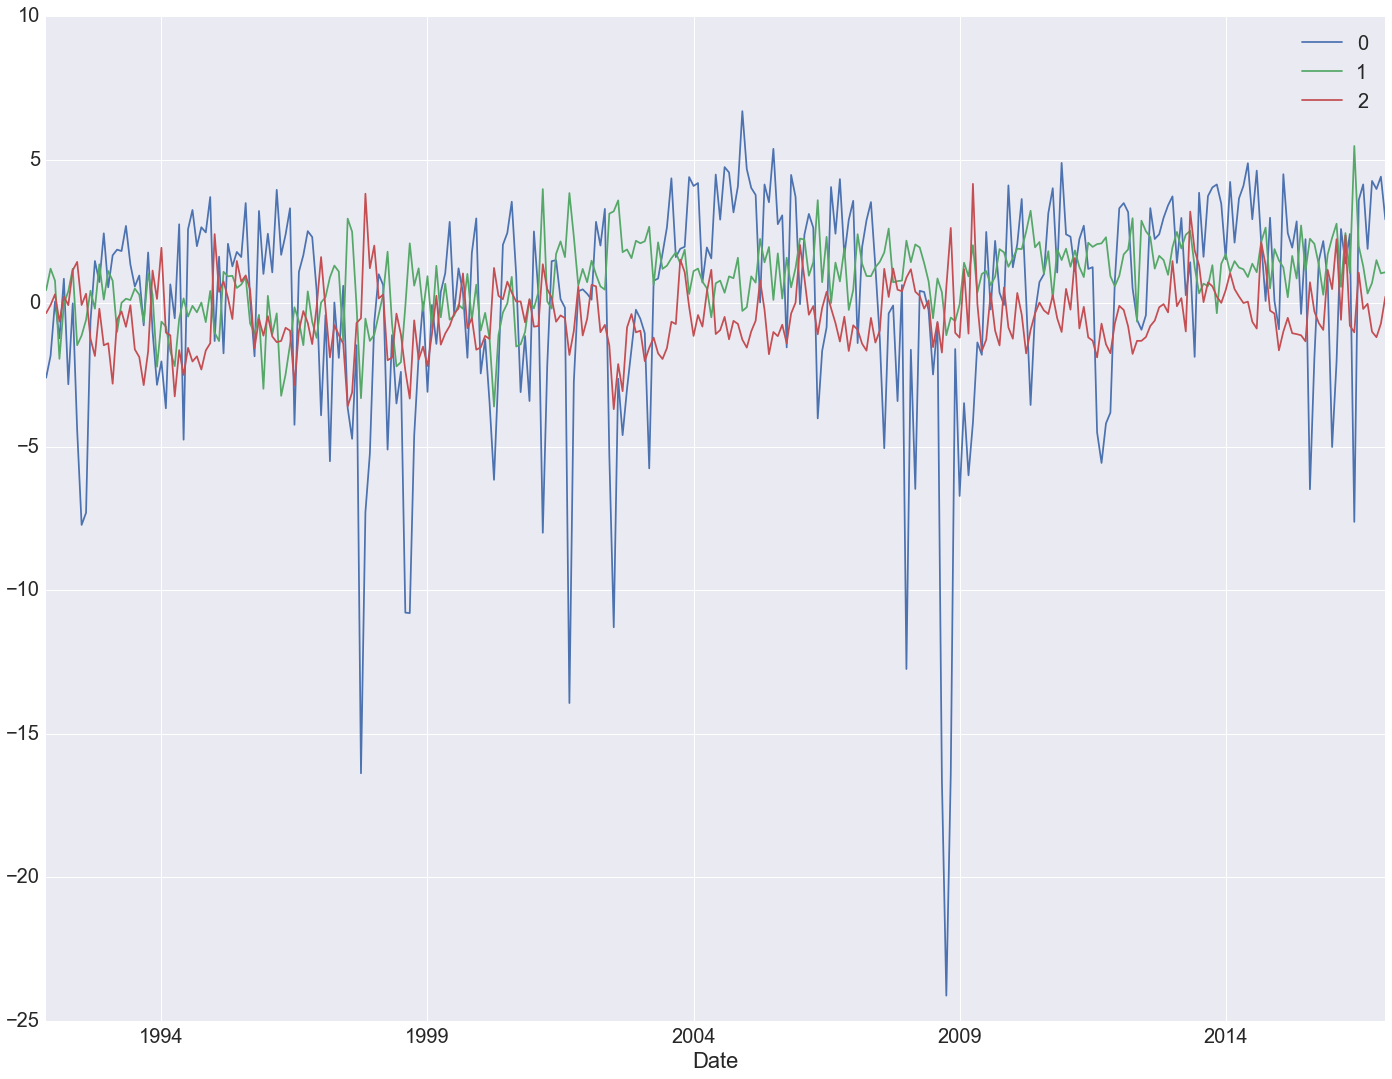

In [28]:
sector_PC['Equities'].plot()

In [29]:
resFHT = VAR.VAR(endog=prin_factors_FHT['2000':'2016'])

In [30]:
resFHT.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -3.452       -3.332      0.03170       -3.403
1        -4.395      -3.438*      0.01234      -4.008*
2       -4.549*       -2.754     0.01060*       -3.822
3        -4.360       -1.728      0.01288       -3.294
4        -4.196      -0.7263      0.01532       -2.790
5        -4.000       0.3068      0.01892       -2.255
6        -3.762        1.381      0.02456       -1.679
7        -3.668        2.314      0.02790       -1.245
8        -3.537        3.282      0.03325      -0.7749
9        -3.393        4.263      0.04071      -0.2915
10       -3.292        5.202      0.04853       0.1489
11       -3.288        6.043      0.05349       0.4915
12       -3.224        6.945      0.06411       0.8953
13       -3.388        7.618      0.06277        1.070
14       -3.428        8.415      0.07178        1.369
* Minimum


{'aic': 2, 'bic': 1, 'fpe': 2, 'hqic': 1}

In [31]:
print resFHT.fit(1).summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, May, 2018
Time:                     10:04:02
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -3.48449
Nobs:                     203.000    HQIC:                  -4.02871
Log likelihood:          -1513.87    FPE:                  0.0122996
AIC:                     -4.39848    Det(Omega_mle):      0.00938394
--------------------------------------------------------------------
Results for equation Agriculturals
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.187400         0.151195            1.239           0.217
L1.Agriculturals         0.260297         0.074023            3.516           0.001
L1.Currencies           -0.235691       

In [32]:
y=resFHT.fit(1)

In [33]:
cols=[ u'L1.Agriculturals', u'L1.Currencies', u'L1.Energies',
       u'L1.Equities', u'L1.Metals', u'L1.Fixed Income', u'L1.Total']
print y.params.T[cols].round(3).to_latex()

\begin{tabular}{lrrrrrrr}
\toprule
{} &  L1.Agriculturals &  L1.Currencies &  L1.Energies &  L1.Equities &  L1.Metals &  L1.Fixed Income &  L1.Total \\
\midrule
Agriculturals &             0.260 &         -0.236 &        0.184 &       -0.070 &     -0.125 &            0.302 &     0.250 \\
Currencies    &            -0.059 &          0.096 &       -0.038 &       -0.094 &      0.266 &            0.212 &     0.240 \\
Energies      &             0.021 &         -0.006 &        0.544 &       -0.135 &     -0.005 &            0.004 &     0.064 \\
Equities      &            -0.012 &         -0.144 &       -0.208 &        0.450 &      0.268 &           -0.228 &    -0.056 \\
Metals        &            -0.073 &         -0.180 &        0.012 &        0.140 &      0.362 &           -0.168 &    -0.023 \\
Fixed Income  &             0.045 &          0.001 &        0.026 &       -0.019 &     -0.309 &           -0.065 &    -0.178 \\
Total         &             0.054 &         -0.098 &       -0.329 &    

In [34]:
y.params.T.columns

Index([u'const', u'L1.Agriculturals', u'L1.Currencies', u'L1.Energies',
       u'L1.Equities', u'L1.Metals', u'L1.Fixed Income', u'L1.Total'],
      dtype='object')

In [35]:
pvaluesFHT=pd.DataFrame()
for col in y.tvalues.columns:
    s=pd.Series()
    for col2 in y.tvalues.columns:
        s[col2]=y.test_causality(col,col2).values()[4]
    pvaluesFHT[col]=s

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
        12.365408         3.848280            0.000  (1, 1365)
H_0: ['Agriculturals'] do not Granger-cause Agriculturals
Conclusion: reject H_0 at 5.00% significance level
Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         3.038896         3.848280            0.082  (1, 1365)
H_0: ['Currencies'] do not Granger-cause Agriculturals
Conclusion: fail to reject H_0 at 5.00% significance level
Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         3.489256         3.848280            0.062  (1, 1365)
H_0: ['Energies'] do not Granger-cause Agriculturals
Conclusion: fail to reject H_0 at 5.00% significance level
Granger causality f-tes

In [36]:
print pvaluesFHT.round(3).T.to_latex()

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income &  Total \\
\midrule
Agriculturals &          0.000 &       0.082 &     0.062 &     0.448 &   0.136 &         0.086 &  0.025 \\
Currencies    &          0.335 &       0.391 &     0.646 &     0.221 &   0.000 &         0.147 &  0.010 \\
Energies      &          0.717 &       0.957 &     0.000 &     0.067 &   0.943 &         0.977 &  0.470 \\
Equities      &          0.892 &       0.374 &     0.077 &     0.000 &   0.008 &         0.280 &  0.676 \\
Metals        &          0.290 &       0.151 &     0.900 &     0.103 &   0.000 &         0.305 &  0.827 \\
Fixed Income  &          0.450 &       0.995 &     0.736 &     0.797 &   0.000 &         0.643 &  0.045 \\
Total         &          0.663 &       0.664 &     0.045 &     0.534 &   0.000 &         0.628 &  0.009 \\
\bottomrule
\end{tabular}



In [37]:
y.tvalues.T.round(2)

,const,L1.Agriculturals,L1.Currencies,L1.Energies,L1.Equities,L1.Metals,L1.Fixed Income,L1.Total
Agriculturals,1.24,3.52,-1.74,1.87,-0.76,-1.49,1.72,2.24
Currencies,-0.06,-0.97,0.86,-0.46,-1.22,3.82,1.45,2.58
Energies,-0.42,0.36,-0.05,6.93,-1.84,-0.07,0.03,0.72
Equities,1.01,-0.14,-0.89,-1.77,4.07,2.68,-1.08,-0.42
Metals,-2.59,-1.06,-1.44,0.13,1.63,4.66,-1.03,-0.22
Fixed Income,-6.74,0.76,0.01,0.34,-0.26,-4.64,-0.46,-2.00
Total,2.96,0.44,-0.43,-2.00,0.62,4.18,0.48,2.61


In [38]:
y.pvalues.T.round(3)

,const,L1.Agriculturals,L1.Currencies,L1.Energies,L1.Equities,L1.Metals,L1.Fixed Income,L1.Total
Agriculturals,0.217,0.001,0.083,0.063,0.448,0.137,0.088,0.026
Currencies,0.950,0.336,0.392,0.646,0.223,0.000,0.149,0.011
Energies,0.677,0.717,0.957,0.000,0.068,0.943,0.977,0.470
Equities,0.313,0.892,0.375,0.079,0.000,0.008,0.281,0.676
Metals,0.010,0.291,0.153,0.900,0.104,0.000,0.306,0.827
Fixed Income,0.000,0.451,0.995,0.736,0.797,0.000,0.644,0.046
Total,0.003,0.663,0.664,0.047,0.535,0.000,0.628,0.010


In [39]:
print y.resid.corr().round(2).to_latex()

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income &  Total \\
\midrule
Agriculturals &           1.00 &       -0.25 &      0.17 &     -0.26 &   -0.14 &          0.33 &  -0.43 \\
Currencies    &          -0.25 &        1.00 &     -0.23 &      0.32 &    0.16 &         -0.73 &   0.69 \\
Energies      &           0.17 &       -0.23 &      1.00 &     -0.27 &   -0.07 &          0.29 &  -0.51 \\
Equities      &          -0.26 &        0.32 &     -0.27 &      1.00 &    0.39 &         -0.47 &   0.70 \\
Metals        &          -0.14 &        0.16 &     -0.07 &      0.39 &    1.00 &         -0.29 &   0.24 \\
Fixed Income  &           0.33 &       -0.73 &      0.29 &     -0.47 &   -0.29 &          1.00 &  -0.81 \\
Total         &          -0.43 &        0.69 &     -0.51 &      0.70 &    0.24 &         -0.81 &   1.00 \\
\bottomrule
\end{tabular}

